In [2]:
from qmt import Materials
from qmt.physics_constants import parse_unit,to_float
from qmt.tasks import build_3d_geometry
from qmt.data import Part3DData
import pickle, logging
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata

For full shell:

In [6]:
back_gate = Part3DData('back_gate','Sketch','extrude',
                       domain_type='metal_gate',material='Al',
                       z0=-0.2,thickness=0.1,boundary_condition={'voltage':0.0},mesh_max_size=0.1)
vacuum = Part3DData('vacuum','Sketch003','extrude',
                    domain_type='dielectric',material='air',
                    z0=-0.5,thickness=1.0,mesh_max_size=0.05)
wire = Part3DData('wire','Sketch002','extrude',
                  domain_type='semiconductor',material='InSb',
                  z0 = 0.0,thickness=0.1,mesh_max_size=0.01)
shell = Part3DData('shell','Sketch002','extrude',
                  domain_type='metal_gate',material='Al',
                  z0 = 0.1,thickness=0.05,mesh_max_size=0.01,boundary_condition={'voltage':0.0})
build_order = [wire,shell,back_gate,vacuum]
file_path = '/app/notebook/simple_wire.FCStd'
geo_data = build_3d_geometry(input_parts=build_order,input_file=file_path,
                             xsec_dict={'central':{'axis':(1.,0.,0.),'distance':0.}})
geo_data.write_fcstd('built_geo.fcstd')

'built_geo.fcstd'

In [27]:
geo_data.xsecs

{'central': {'axis': (1.0, 0.0, 0.0),
  'distance': 0.0,
  'polygons': {'wire_0': [<map at 0x7f32d164f8d0>,
   'shell_0': [<map at 0x7f32d1653048>,
   'back_gate_0': [<map at 0x7f32d1653748>,
   'vacuum_0': [<map at 0x7f32d1656908>,
   'vacuum_1': [<map at 0x7f32d1656ac8>,
   'vacuum_2': [<map at 0x7f32d1656d30>,
    <map at 0x7f32d1656ef0>]}}}

In [28]:
geo_data.parts

{'wire': <qmt.data.geometry.Part3DData at 0x7f32df586e48>,
 'shell': <qmt.data.geometry.Part3DData at 0x7f32df586dd8>,
 'back_gate': <qmt.data.geometry.Part3DData at 0x7f32df586e10>,
 'vacuum': <qmt.data.geometry.Part3DData at 0x7f32df586ef0>}

Mesh the model (save it for later use so we don't need to re-run):

In [3]:
with open('mesh_data.pkl','rb') as file:
    mesh_data = pickle.load(file)

Determine the reference level and Al work function to get a 0.1 meV band offset between InSb and Al:

In [132]:
mat_lib = Materials()
Al_WF = mat_lib['Al']['workFunction']
InSb_EA = mat_lib['InSb']['electronAffinity']
InSb_BG = mat_lib['InSb']['directBandGap']
InSb_VBO = mat_lib['InSb']['valenceBandOffset']
Al_WF_level = 0.0-(Al_WF)
InSb_CB_level = 0.0-InSb_EA+InSb_VBO
WF_shift = 100.*parse_unit('meV')-(Al_WF_level-InSb_CB_level)
new_Al_WF = (Al_WF-WF_shift)
ref_level = -new_Al_WF/parse_unit('meV')

In [137]:
# You won't be able to run the simulation with QMT alone. Here we just load the file with simulation results
# logging.basicConfig(level=logging.INFO)
# tf_data = run_3d_thomas_fermi(mesh_data,
#                               reference_level=ref_level,
#                               material_properties={'Al':{'workFunction':new_Al_WF}},
#                               eunit='meV',volume_charge_integrals=['wire'],order=1)
with open('tf_data.pkl','rb') as file:
    tf_data = pickle.load(file)

First, let's check that all of the boundary conditions are respected:

In [31]:
mesh_data.mesh_id_dict

{'wire': 3, 'shell': 4, 'back_gate': 2, 'vacuum': 1}

In [32]:
node_vals = []
for i in range(len(mesh_data.mesh_regions)):
    region_id = mesh_data.mesh_regions[i]
    if region_id == 2 or region_id==4:
        for node_idx in mesh_data.mesh_tets[i]:
            node_vals += [tf_data.potential[node_idx]]
assert np.alltrue(np.array(node_vals)==0.0)

Great! Let's take a look at the potential profile to make sure it looks reasonable:

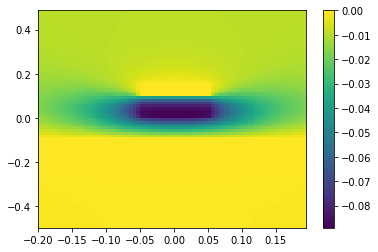

In [125]:
femcoords = tf_data.coordinates
femdata = tf_data.potential
xgrid, ygrid, zgrid = np.mgrid[0:1, -0.2:0.2:0.005, -0.5:0.5:0.0125]
plot_potential = griddata(femcoords, femdata, (xgrid, ygrid, zgrid), method='linear')
plt.pcolor(ygrid[0],zgrid[0],plot_potential[0])
plt.colorbar()
plt.show()

This looks fine. Let's now look at a line cut:

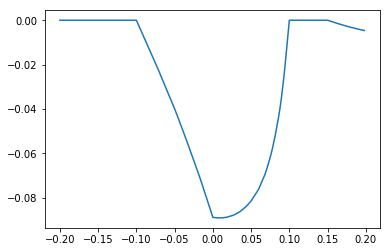

In [129]:
xgrid, ygrid, zgrid = np.mgrid[0:1, 0:1, -0.2:0.2:0.002]
potential_cut = griddata(femcoords, femdata, (xgrid, ygrid, zgrid), method='linear')
plt.plot(zgrid[0,0],potential_cut[0,0])
plt.show()

This all looks fine. In the region between 0.0 and 0.1, we have accumulation. Let's make sure this holds up when taking into account the conduction band offset:

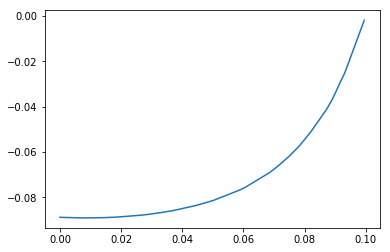

In [130]:
xgrid, ygrid, zgrid = np.mgrid[0:1, 0:1, 0:0.1:0.0005]
potential_cut = griddata(femcoords, femdata, (xgrid, ygrid, zgrid), method='linear')
plt.plot(zgrid[0,0],potential_cut[0,0])
plt.show()

Putting in the proper band offsets, we get:

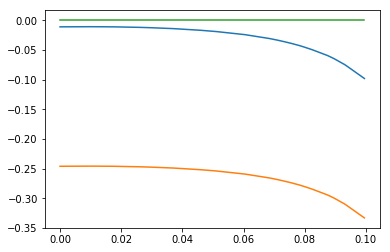

In [136]:
zvec = zgrid[0,0]
potential_cut = potential_cut[0,0]
offset_CB = (InSb_CB_level/parse_unit('meV')-ref_level)/1e3
offset_VB = offset_CB-InSb_BG/parse_unit('meV')/1e3
plt.plot(zvec,offset_CB-potential_cut)
plt.plot(zvec,offset_VB-potential_cut)
plt.plot(zvec,np.zeros(zvec.shape))
plt.show()